In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [3]:
# loading the data
df = pd.read_csv('../../data/LSTMGamesStandardized.csv')

In [4]:
min_season = 2011
# Try with a shorter season
df = df[df['SEASON'] >= min_season]

In [53]:
df.iloc[:,2:].tail(20)

,TEAM_ID,FGM_DIFF,FGA_DIFF,FG3M_DIFF,FTM_DIFF,FTA_DIFF,OREB_DIFF,DREB_DIFF,AST_DIFF,STL_DIFF,TOV_DIFF,PF_DIFF,PTS_DIFF,WIN,HOME_GAME
37996,1610612766,-1.0,-1,-5,5.0,4.0,1,-1,-8,-1,-1,-3.0,-2,0,1
37997,1610612766,-8.0,-4,-7,12.0,13.0,-4,-7,-12,4,-3,-7.0,-11,0,1
37998,1610612766,-3.0,-8,-1,2.0,3.0,1,10,2,-2,8,0.0,-5,0,1
37999,1610612766,6.0,8,-1,0.0,-1.0,3,0,-3,4,-3,6.0,11,1,0
38000,1610612766,-6.0,-13,3,-1.0,0.0,-9,-4,-1,-2,1,-2.0,-10,0,1
38001,1610612766,-8.0,-8,5,4.0,4.0,-7,-4,3,-3,3,3.0,-7,0,1
38002,1610612766,0.0,10,5,-4.0,-6.0,5,1,-4,-1,0,-1.0,1,1,1
38003,1610612766,0.0,3,-2,-15.0,-16.0,-8,-12,-2,-5,0,7.0,-17,0,0
38004,1610612766,0.0,-2,-1,-11.0,-12.0,-5,-11,-2,-3,-2,3.0,-12,0,0
38005,1610612766,5.0,17,1,-5.0,-7.0,7,-6,-7,3,-5,3.0,6,1,0


In [6]:
split_fraction = 0.80
step = 1
past = 7
future = 0
learning_rate = 0.001
batch_size = 256
epochs = 100

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [7]:
team_list = pd.unique(df['TEAM_ID'])

# Create None type for dataset
combined_dataset_train = None
combined_dataset_val = None

for team_id in team_list: 
    team_df = df[df['TEAM_ID'] == team_id]
    
    feature_ids = [3,4,5,6,7,8,9,10,11,12,13,14,15]
    team_features = team_df.iloc[:,feature_ids]
    team_features.index = team_df['GAME_DATE']
    team_train_split = int(split_fraction * int(team_df.shape[0]))
    
    # For now we are normalizing per team
    norm_team_features = normalize(team_features.values, team_train_split)
    
    norm_team_features = pd.DataFrame(norm_team_features)
    team_features = pd.DataFrame(team_features.values)
    
    train_data = norm_team_features.loc[0 : team_train_split - 1]
    val_data = norm_team_features.loc[team_train_split:]
    
    # Create Training Dataset
    start = past + future
    end = start + team_train_split

    x_train = train_data[[i for i in range(len(feature_ids) - 1)]].values
    y_train = team_features.iloc[start:end][[12]]

    sequence_length = int(past / step)
    
    dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

    x_end = len(val_data) - past - future

    # Validation Dataset now
    label_start = team_train_split + past + future

    x_val = val_data.iloc[:x_end][[i for i in range(len(feature_ids) - 1)]].values
    y_val = team_features.iloc[label_start:][[12]]

    
    dataset_val = keras.preprocessing.timeseries_dataset_from_array(
        x_val,
        y_val,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )

    if combined_dataset_train is None:
        combined_dataset_train = dataset_train
        combined_dataset_val = dataset_val
    else:
        combined_dataset_train = dataset_train.concatenate(dataset_train)
        combined_dataset_val = combined_dataset_val.concatenate(dataset_val) 
    
    

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-14 09:52:42.812262: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-14 09:52:42.812580: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
for batch in combined_dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

for batch in combined_dataset_val.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)


2022-12-14 09:52:47.699707: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Input shape: (256, 7, 12)
Target shape: (256, 1)
Input shape: (101, 7, 12)
Target shape: (101, 1)


In [9]:
# Use Keras LSTM layer to consruct a model
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32,dropout=0.5)(inputs)
outputs = keras.layers.Dense(1, activation='sigmoid')(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 12)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                5760      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,793
Trainable params: 5,793
Non-trainable params: 0
_________________________________________________________________


In [10]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", min_delta=0, patience=20)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_binary_accuracy",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    combined_dataset_train,
    epochs=epochs,
    validation_data=combined_dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/100


2022-12-14 09:52:54.016539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 09:52:54.213876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 3s - loss: 0.6973 - binary_accuracy: 0.5078

2022-12-14 09:52:54.429890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 0.6975 - binary_accuracy: 0.5032

2022-12-14 09:52:55.256298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-14 09:52:55.320319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_binary_accuracy improved from -inf to 0.53626, saving model to model_checkpoint.h5
4/4 [==============================] - 3s 620ms/step - loss: 0.6975 - binary_accuracy: 0.5032 - val_loss: 0.6901 - val_binary_accuracy: 0.5363
Epoch 2/100
3/4 [=====================>........] - ETA: 0s - loss: 0.6820 - binary_accuracy: 0.5885
Epoch 2: val_binary_accuracy improved from 0.53626 to 0.54803, saving model to model_checkpoint.h5
4/4 [==============================] - 1s 219ms/step - loss: 0.6859 - binary_accuracy: 0.5698 - val_loss: 0.6874 - val_binary_accuracy: 0.5480
Epoch 3/100
3/4 [=====================>........] - ETA: 0s - loss: 0.6710 - binary_accuracy: 0.6283
Epoch 3: val_binary_accuracy improved from 0.54803 to 0.55121, saving model to model_checkpoint.h5
4/4 [==============================] - 1s 236ms/step - loss: 0.6763 - binary_accuracy: 0.6036 - val_loss: 0.6855 - val_binary_accuracy: 0.5512
Epoch 4/100
3/4 [=====================>........] - ETA: 0s - loss: 0.6606 - 

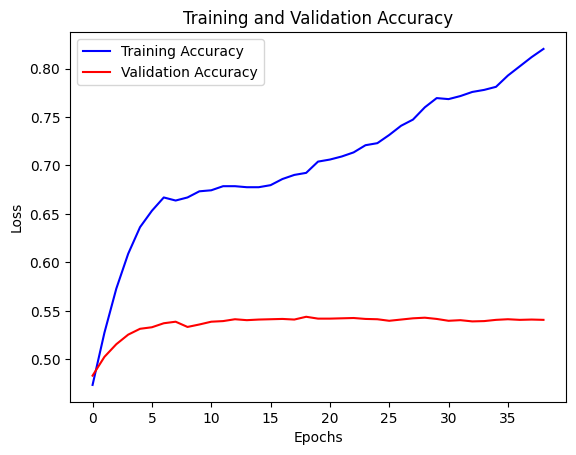

In [12]:

def visualize_loss(history, title):
    accuracy = history.history["binary_accuracy"]
    val_accuracy = history.history["val_binary_accuracy"]
    epochs = range(len(accuracy))
    plt.figure()
    plt.plot(epochs, accuracy, "b", label="Training Accuracy")
    plt.plot(epochs, val_accuracy, "r", label="Validation Accuracy")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Accuracy")

In [11]:
for x,y in dataset_val.take(1):
    print(model.predict(x)[2])
    print(y[2])

4/4 [==============================] - 0s 19ms/step


2022-12-08 12:57:15.578676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-08 12:57:15.636197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[0.6843516]
tf.Tensor([0.], shape=(1,), dtype=float64)


In [44]:
model.load_weights('model_checkpoint.h5')

In [45]:
y_pred = None
y_true = None
for x,y in combined_dataset_val:
    temp_pred = np.rint(model.predict(x)).flatten()
    temp_y = y.numpy().flatten()
    if y_pred is None:
        y_pred = temp_pred
        y_true = y
    else:
        y_pred = np.append(y_pred,temp_pred)
        y_true = np.append(y_true,y)

4/4 [==============================] - 0s 4ms/step


In [21]:
from sklearn.metrics import confusion_matrix

In [46]:
confusion_matrix(y_true,y_pred)

array([[1143,  424],
       [ 965,  612]])

In [48]:
for x,y in combined_dataset_train.take(1):
    print(x[0])
    print(y[0])

tf.Tensor(
[[ 0.99609667  0.3195222  -0.58107665 -0.72899701 -0.57729918  1.30514796
   1.02195905  1.23214668 -0.82500226  0.97228962  0.50215437  0.31415629]
 [ 0.8350672   0.54727686  1.62094642 -2.09035986 -1.70643885  1.86516516
   1.97698378  0.77977193 -0.5459231   2.69401505  1.52308792  0.17063615]
 [-0.77522744 -0.02210979 -1.24168357 -0.32058816 -1.02895504 -0.37490365
  -0.61522619 -0.27576916  0.84947266  0.11142691  1.93146134 -1.26456522]
 [-1.74140423  1.4582955   0.07953027 -1.95422357 -1.48061091  1.11847556
  -1.57025091 -1.63289342 -0.26684395  0.32664258  0.91052779 -2.55624645]
 [-0.45316851  0.09176754 -1.02148127 -0.04831559 -1.14186901  0.18511355
   0.74909485 -0.42656074 -1.94131887  0.97228962  1.1147145  -0.76224474]
 [ 1.15712613  0.09176754 -0.58107665 -0.04831559 -0.23855727 -0.74824846
   0.33979854  1.53372985  0.29131436 -0.53422013 -0.31459247  0.81647677]
 [ 0.02991988 -0.81925111  0.29973258 -0.59286073 -0.69021314 -0.56157606
   0.20336643 -0.5773